# Image Segmentation using Fully Convolutional Network (FCN)
---
## Instructions
- In this assignment, we will perform semantic segmentation on PASCAL VOC 2011 dataset which contains 20 object categories. We use the Semantic Boundaries Dataset (SBD) as it contains more segmentation labels than the original dataset.
- To this end, you need to implement necessary network components, load and fine-tune the pretrained network, and report segmentation performance on the validation set.
- Also, you have to download a pretrained VGG network [here](https://drive.google.com/file/d/1HbA8D08-dgglvB9nDCpLYwhgaDOOmPBP/view?usp=sharing). Upload it to your drive, place it in the same directory with your Colab notebook.
- <font color="red">You'll be training large models. We recommend you to create at least **6GB** of space available on your drive to run everything properly.</font>

---
## Prerequisite: Setup the `root` directory properly.

In [1]:
# Specify the directory path where `Segmentation.ipynb` exists.
# For example, if you saved `Segmentation.ipynb` in `/drive/Segmentation_FCN` directory,
# then set root = '/drive/Segmentation_FCN'
root = "./" 

---
# Basic settings

## Import libraries

In [2]:
import os
import time
import traceback
import logging
from easydict import EasyDict as edict
import numpy as np
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import VOCSegmentation, SBDataset
from torchvision.datasets.vision import StandardTransform
from torchvision.models.vgg import VGG, vgg16, make_layers
import torchvision.models as models

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(True)

!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-gb10dysn
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-gb10dysn
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Hyperparameters

In [3]:
# Basic settings
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']}

torch.manual_seed(42)
torch.cuda.manual_seed(42)

args = edict()
args.batch_size = 1
args.lr = 1e-4
args.momentum = 0.9
args.weight_decay = 5e-4
args.epoch = 2
args.tensorboard = True
args.gpu = True

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

## Tensorboard

In [ ]:
# Setup tensorboard.
if args.tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir "./results" --samples_per_plugin images=100
else:
    writer = None

---
# Utility functions

Here are some utility functions that we will use throughout this assignment. You don't have to modify any of these.  
**Conditional Random Field (CRF)** is a technique to further improve segmentation performance, mainly focusing on better localization. Details can be found in the [DeepLab](https://arxiv.org/abs/1606.00915) paper.

In [4]:
def get_parameters(model, bias=False):
    """ Extracts weight and bias parameters from a model. """
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None


def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """ Make a 2D bilinear kernel suitable for upsampling
        https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
    """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()


class toLongTensor:
    """ Convert a byte tensor to a long tensor """
    def __call__(self, img):
        output = torch.from_numpy(np.array(img).astype(np.int32)).long()
        output[output == 255] = 21
        return output


def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """ Returns overall accuracy and mean IoU """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iou = np.nanmean(iou)
    return acc, mean_iou


class Colorize(object):
    """ Colorize the segmentation labels """
    def __init__(self, n=35, cmap=None):
        if cmap is None:
            raise NotImplementedError()
            self.cmap = labelcolormap(n)
        else:
            self.cmap = cmap
        self.cmap = self.cmap[:n]

    def preprocess(self, x):
        if len(x.size()) > 3 and x.size(1) > 1:
            # if x has a shape of [B, C, H, W],
            # where B and C denote a batch size and the number of semantic classe
            # then translate it into a shape of [B, 1, H, W]
            x = x.argmax(dim=1, keepdim=True).float()
        assert (len(x.shape) == 4) and (x.size(1) == 1), 'x should have a shape of [B, 1, H, W]'
        return x

    def __call__(self, x):
        x = self.preprocess(x)
        if (x.dtype == torch.float) and (x.max() < 2):
            x = x.mul(255).long()
        color_images = []
        gray_image_shape = x.shape[1:]
        for gray_image in x:
            color_image = torch.ByteTensor(3, *gray_image_shape[1:]).fill_(0)
            for label, cmap in enumerate(self.cmap):
                mask = (label == gray_image[0]).cpu()
                color_image[0][mask] = cmap[0]
                color_image[1][mask] = cmap[1]
                color_image[2][mask] = cmap[2]
            color_images.append(color_image)
        color_images = torch.stack(color_images)
        return color_images


def uint82bin(n, count=8):
    """ Returns the binary of integer n, count refers to amount of bits """
    return ''.join([str((n >> y) & 1) for y in range(count-1, -1, -1)])


def get_color_map():
    """ Returns N color map """
    N=25
    color_map = np.zeros((N, 3), dtype=np.uint8)
    for i in range(N):
        r, g, b = 0, 0, 0
        id = i
        for j in range(7):
            str_id = uint82bin(id)
            r = r ^ (np.uint8(str_id[-1]) << (7-j))
            g = g ^ (np.uint8(str_id[-2]) << (7-j))
            b = b ^ (np.uint8(str_id[-3]) << (7-j))
            id = id >> 3
        color_map[i, 0] = r
        color_map[i, 1] = g
        color_map[i, 2] = b
    color_map = torch.from_numpy(color_map)
    return color_map


def dense_crf(img, output_probs):
    """ Conditional Random Field for better segmentation
        Refer to https://github.com/lucasb-eyer/pydensecrf for details.
    """
    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=1, compat=3)
    d.addPairwiseBilateral(sxy=67, srgb=3, rgbim=img, compat=4)

    Q = d.inference(10)
    Q = np.array(Q).reshape((c, h, w))
    return Q


def add_padding(img):
    """ Zero-pad image(or any array-like object) to 500x500. """
    w, h = img.shape[-2], img.shape[-1]
    MAX_SIZE = 500
    IGNORE_IDX = 21

    assert max(w, h) <= MAX_SIZE, f'both height and width should be less than {MAX_SIZE}'

    _pad_left = (MAX_SIZE - w) // 2
    _pad_right = (MAX_SIZE - w + 1) // 2
    _pad_up = (MAX_SIZE - h) // 2
    _pad_down = (MAX_SIZE - h + 1) // 2

    _pad = (_pad_up, _pad_down, _pad_left, _pad_right)

    padding_img = transforms.Pad(_pad)
    padding_target = transforms.Pad(_pad, fill=IGNORE_IDX)

    img = F.pad(img, pad=_pad)
    return img

---
# Define `DataLoader` for training & validation set

If the cell below fails with error message "Destination path `./cls` already exists", try again with `download=False`.

In [5]:
mean = [.485, .456, .406]
std = [.229, .224, .225]

# define transform functions.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
transform_train_target = transforms.Compose([
    toLongTensor()
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
transform_test_target = transforms.Compose([
    toLongTensor()
])

# define dataloader.
sbd_transform_train = StandardTransform(transform_train, transform_train_target)
sbd_transform_test = StandardTransform(transform_test, transform_test_target)
try:
  train_dataset = SBDataset(root=root, image_set='train', mode='segmentation', download=True, transforms=sbd_transform_train)
except:
  train_dataset = SBDataset(root=root, image_set='train', mode='segmentation', download=False, transforms=sbd_transform_train)
test_dataset = SBDataset(root=root, image_set='val', mode='segmentation', download=False, transforms=sbd_transform_test)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

100%|██████████| 1419539633/1419539633 [02:11<00:00, 10783229.42it/s]


Extracting ./benchmark.tgz to .


---
# Descript VGG16 Network

In [6]:
class ClassificationCNN(VGG):
    def __init__(self):
        super().__init__(make_layers(cfg['vgg16']))

print(ClassificationCNN())

ClassificationCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

## Create VGG16 Pretrain Weight

In [7]:
torch.save(models.vgg16(pretrained=True).state_dict(), 'pretrained_vgg16.pt')

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Part 1. Implement FCN32 [(Illustration)](https://docs.google.com/drawings/d/1Vlm1kdIH9MZiJU_gLFhVNO_-alFGWyxLF_zSmQxkaO0/edit?usp=sharing)

### (a) Declare convolutional layers as an alternative to FC layers
The VGG16 backbone contains two fully connected layers (fc6, fc7). In fully convolutional network, these fc layers will be convolutionized. You should define proper convolutional layers, which will be initialized from fc layers of pretrained model in section (d).

### (b) Declare pixel-wise classification layer using 1x1 convolution
This section declares 1x1 convolution layer that produces classification per pixel

### (c) Declare a deconvolution layer
Declare a learnable upsampling layer.

### (d) Load pretrained weights
As mentioned in section (a), you should convolutionize the two fc layers(fc6, fc7) of pretrained model inside `load_pretrained` method. Initialize two convolutional layers with fc6, fc7 layers of the pretrained model, respectively.

### (e) Implement `forward` method
The `forward` method should
- Feed input through the backbone to get `pool5` (given)
- On top of `pool5`, perform pixel-wise classification.
- Upsample the prediction to create segmentation on the original image resolution level.

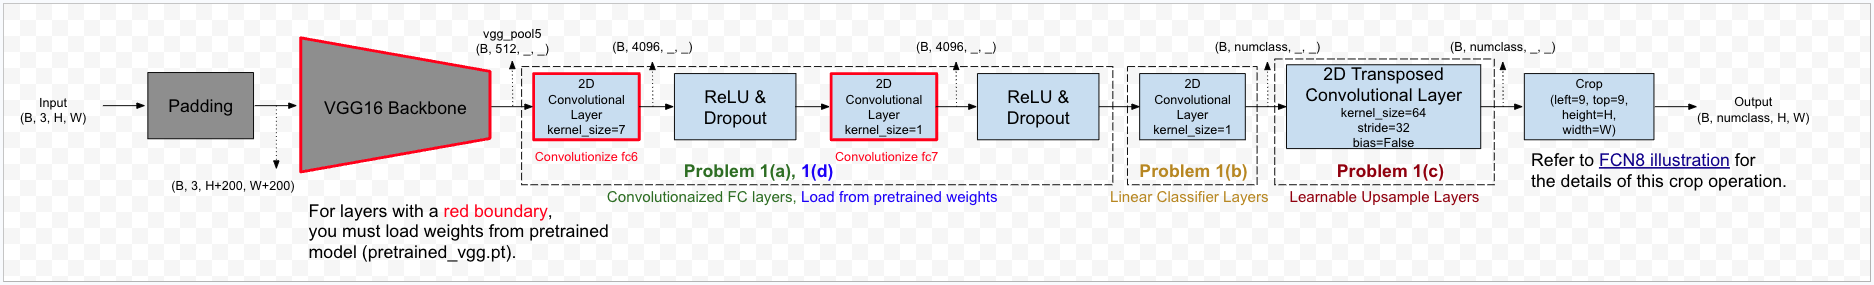

In [8]:
class FCN32(VGG):
    def __init__(self):
        super().__init__(make_layers(cfg['vgg16']))

        self.numclass = 21

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d()

        # fc layers in vgg are all converted into conv layers.
        #################################
        ## P1(a). Write your code here ##
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=7)
        self.conv7 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=1)
        #################################

        # prediction layer with 1x1 convolution layer.
        #################################
        ## P1(b). Write your code here ##
        self.score_x32 = nn.Conv2d(in_channels=4096, out_channels=self.numclass, kernel_size=1)
        #################################

        # learnable upsampling layers in FCN model.
        #################################
        ## P1(c). Write your code here ##
        self.deconv1 = nn.ConvTranspose2d(in_channels=self.numclass, 
                                          out_channels=self.numclass,
                                          kernel_size=64, stride=32, bias=False)
        #################################

        # initialize
        self._initialize_weights() # initialize upsampling weight

    def load_pretrained(self, pretrained_model):
        self.features = pretrained_model.features
        fc6 = pretrained_model.classifier[0]
        fc7 = pretrained_model.classifier[3]

        #################################
        ## P1(d). Write your code here ##
        self.conv6.weight.data = fc6.weight.data.view(self.conv6.weight.data.shape)
        self.conv6.bias.data = fc6.bias.data.view(self.conv6.bias.data.shape)
        self.conv7.weight.data = fc7.weight.data.view(self.conv7.weight.data.shape)
        self.conv7.bias.data = fc7.bias.data.view(self.conv7.bias.data.shape)
        #################################

    # initialize transdeconv layer with bilinear upsampling.
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def vgg_layer_forward(self, x, indices):
        output = x
        start_idx, end_idx = indices
        for idx in range(start_idx, end_idx):
            output = self.features[idx](output)
        return output

    def vgg_forward(self, x):
        out = {}
        layer_indices = [0, 5, 10, 17, 24, 31]
        for layer_num in range(len(layer_indices)-1):
            x = self.vgg_layer_forward(x, layer_indices[layer_num:layer_num+2])
            out[f'pool{layer_num+1}'] = x
        return out

    def forward(self, x):
        # padding for aligning to the input size
        padded_x = F.pad(x, [100, 100, 100, 100], "constant", 0)
        vgg_features = self.vgg_forward(padded_x)
        vgg_pool5 = vgg_features['pool5'].detach()
        vgg_pool4 = vgg_features['pool4'].detach()
        vgg_pool3 = vgg_features['pool3'].detach()

        #################################
        ## P1(e). Write your code here
        ## Add more lines as you wish.
        #################################
        # prediction at stride 32.
        out = self.dropout(self.relu(self.conv6(vgg_pool5)))
        out = self.dropout(self.relu(self.conv7(out)))
        pred_x32 = self.score_x32(out)

        # upsample with conv transpose.
        out = self.deconv1(pred_x32)
        out = out[..., 9:9+x.shape[-2], 9:9+x.shape[-1]]

        return out

## FCN32 Tests

This section tests your solution for FCN32. **Please do not modify the code!**

In [9]:
def run_tests_fcn32():
    n_pass, n_test = 0, 11

    try:
        net = FCN32()
        print(f"[TEST  1/{n_test} Passed] FCN32.__init__ executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  1/{n_test} Failed] FCN32.__init__ execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
        net = nn.Identity()

    # P1(a). Declare convolutional layers as an alternative to FC layers
    try:
        assert hasattr(net, 'conv6') and hasattr(net, 'conv7')
        print(f"[TEST  2/{n_test} Passed] FCN32.conv6 and FCN32.conv7 found")
        n_pass += 1
    except AssertionError:
        print(f"[TEST  2/{n_test} Failed] FCN32.conv6 or FCN32.conv7 not found")
        net.conv6 = nn.Identity()
        net.conv7 = nn.Identity()
    try:
        assert net.conv6.weight.data.shape == torch.Size([4096, 512, 7, 7]) and net.conv6.bias.data.shape == torch.Size([4096])
        assert net.conv7.weight.data.shape == torch.Size([4096, 4096, 1, 1]) and net.conv7.bias.data.shape == torch.Size([4096])
        print(f"[TEST  3/{n_test} Passed] FCN32.conv6 and FCN32.conv7 weights and biases have correct shapes")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  3/{n_test} Failed] Some of the FCN32.conv6 and FCN32.conv7 weights and biases have incorrect shapes")

    # P1(b). Declare pixel-wise classification layer using 1x1 convolution
    try:
        assert hasattr(net, 'score_x32')
        print(f"[TEST  4/{n_test} Passed] FCN32.score_x32 found")
        n_pass += 1
    except AssertionError:
        print(f"[TEST  4/{n_test} Failed] FCN32.score_x32 not found")
        net.score_x32 = nn.Identity()
    try:
        assert net.score_x32.weight.data.shape == torch.Size([21, 4096, 1, 1]) and net.score_x32.bias.data.shape == torch.Size([21])
        print(f"[TEST  5/{n_test} Passed] FCN32.score_x32 weights and biases have correct shapes")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  5/{n_test} Failed] Some of the FCN32.score_x32 weights and biases have incorrect shapes")

    # P1(c). Declare a deconvolution layer
    try:
        assert hasattr(net, 'deconv1')
        print(f"[TEST  6/{n_test} Passed] FCN32.deconv1 found")
        n_pass += 1
    except AssertionError:
        print(f"[TEST  6/{n_test} Failed] FCN32.deconv1 not found")
        net.deconv1 = nn.Identity()
    try:
        assert net.deconv1.weight.data.shape == torch.Size([21, 21, 64, 64]) and net.deconv1.bias is None
        print(f"[TEST  7/{n_test} Passed] FCN32.deconv1 weights and biases have correct shapes and configurations")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  7/{n_test} Failed] Some of the FCN32.deconv1 weights and biases have incorrect shapes or configurations")

    # P1(d). Load pretrained weights
    pretrained_model = VGG(make_layers(cfg['vgg16']))
    fc6, fc7 = pretrained_model.classifier[0], pretrained_model.classifier[3]
    try:
        net.load_pretrained(pretrained_model)
        print(f"[TEST  8/{n_test} Passed] FCN32.load_pretrained convolutionization (conv6 <- fc6 and conv7 <- fc7) executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  8/{n_test} Failed] FCN32.load_pretrained convolutionization (conv6 <- fc6 and conv7 <- fc7) execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
    try:
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        x = torch.randn(16, 512, 7, 7)
        x_conv6 = net.conv6(x)
        x_conv7 = net.conv7(x_conv6)
        x_fc6 = fc6(x.view(16, -1))
        x_fc7 = fc7(x_fc6)
        assert (x_conv6 - x_fc6.view(16, 4096, 1, 1)).abs().max() <= 1e-4 and (x_conv7 - x_fc7.view(16, 4096, 1, 1)).abs().max() <= 1e-4
        print(f"[TEST  9/{n_test} Passed] FCN32.load_pretrained convolutionization (conv6 <- fc6 and conv7 <- fc7) is correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  9/{n_test} Failed] FCN32.load_pretrained convolutionization (conv6 <- fc6 and conv7 <- fc7) is incorrect")

    # P1(e). Implement forward method
    net.eval()
    x = train_dataset[100][0].unsqueeze(0)
    try:
        pred = net(x)
        print(f"[TEST 10/{n_test} Passed] FCN32.forward executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST 10/{n_test} Failed] FCN32.forward execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
    try:
        pred = net(x)
        assert pred.shape == torch.Size([1, 21, x.shape[-2], x.shape[-1]])
        print(f"[TEST 11/{n_test} Passed] FCN32.forward output shape is correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST 11/{n_test} Failed] FCN32.forward output shape is incorrect")

    # Not caculate mean, varience
    '''
    try:
        net.score_x32.weight.data.fill_(0.01)
        net.score_x32.bias.data.fill_(0.01)
        pred = net(x)
        assert (pred.abs().mean() - (2.5568814277648926)).abs() <= 1e-5 and (pred.abs().std() - 2.5568814277648926) <= 1e-5
        print(f"[TEST 12/{n_test} Passed] FCN32.forward output mean and std are correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST 12/{n_test} Failed] FCN32.forward output mean and std are incorrect; {(pred.abs().mean().item(), pred.abs().std().item())}")
    try:
        net.score_x32.weight.data.fill_(0.01)
        net.score_x32.bias.data.fill_(0.01)
        pred = net(x)
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        rand_loss = (pred - torch.randn_like(pred)).mean()
        net.zero_grad()
        rand_loss.backward()
        assert (net.conv6.weight.grad.abs().mean() - (0.0002854169288184494)).abs() <= 1e-8 and (net.conv6.weight.grad.abs().std() - 0.0006842449656687677) <= 1e-8
        print(f"[TEST 13/{n_test} Passed] FCN32.forward conv6.weight gradient mean and std are correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST 13/{n_test} Failed] FCN32.forward conv6.weight gradient mean and std are incorrect; {(net.conv6.weight.grad.abs().mean().item(), net.conv6.weight.grad.abs().std().item())}")
    '''

    if n_pass == n_test:
        print(f"\n[TEST] 🎉🎉🥳 All {n_pass}/{n_test} tests passed!")
    else:
        print(f"\n[TEST] {n_pass}/{n_test} tests passed.")


run_tests_fcn32()

[TEST  1/11 Passed] FCN32.__init__ executed without errors
[TEST  2/11 Passed] FCN32.conv6 and FCN32.conv7 found
[TEST  3/11 Passed] FCN32.conv6 and FCN32.conv7 weights and biases have correct shapes
[TEST  4/11 Passed] FCN32.score_x32 found
[TEST  5/11 Passed] FCN32.score_x32 weights and biases have correct shapes
[TEST  6/11 Passed] FCN32.deconv1 found
[TEST  7/11 Passed] FCN32.deconv1 weights and biases have correct shapes and configurations
[TEST  8/11 Passed] FCN32.load_pretrained convolutionization (conv6 <- fc6 and conv7 <- fc7) executed without errors
[TEST  9/11 Passed] FCN32.load_pretrained convolutionization (conv6 <- fc6 and conv7 <- fc7) is correct
[TEST 10/11 Passed] FCN32.forward executed without errors
[TEST 11/11 Passed] FCN32.forward output shape is correct

[TEST] 🎉🎉🥳 All 11/11 tests passed!


## Implement training pipeline

This section contains 2 problems.
### (a) Forward/Backward step for training

- Feed the image through the model.
- Perform a gradient step based on the loss. Loss can be calculated using `criterion`, located at the beginning of the function.
- Choose the highest logit per pixel as prediction.

### (b) Forward step for validation
- Feed the image through the model.
- Calculate loss on current image.
- Choose the highest logit per pixel as prediction.

In [10]:
import tqdm

def get_prediction(criterion, net, image, label):
    #####################################################
    ## P3. Run the model
    ## Add more lines as you wish.
    # output: feed foward.
    # loss: calculate loss as scalar. (Aggregate with .mean()!)
    # pred: choose the label with highest logit in each pixel.
    #####################################################

    output = net(image)
    loss = criterion(output, label).mean()
    pred = torch.argmax(output, dim=1)
    
    return output, loss, pred

In [15]:
def train_net(net, resume=False):
    # 21 is the index for boundaries: therefore we ignore this index.
    criterion = nn.CrossEntropyLoss(ignore_index=21, reduction='none')
    colorize = Colorize(21, get_color_map())
    best_valid_iou = 0

    if resume:
        checkpoint = torch.load(ckpt_path)
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epoch']
        best_valid_iou = checkpoint['best_valid_iou']
        print(f'Resume training from epoch {epoch+1}')
    else:
        epoch = 0

    while epoch < args.epoch:
        t1 = time.time()
        saved_images, saved_labels = [], []

        # start training
        net.train()

        loss_total = 0
        ious = []
        pixel_accs = []

        for batch_idx, (image, label) in tqdm.tqdm(enumerate(train_loader)):
            # save images for visualization.
            if len(saved_images) < 4:
                saved_images.append(image.cpu())
                saved_labels.append(add_padding(label.cpu()))

            # move variables to gpu.
            image = image.to(device)
            label = label.to(device)

            #################################
            ## P3. Run the model           ##
            #################################
            output, loss, pred = get_prediction(criterion, net, image, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # update total loss.
            loss_total += loss.item()

            # target
            target = label.squeeze(1).cpu().numpy()

            # calculate pixel accuarcy and mean IoU
            acc, mean_iu = label_accuracy_score(target, pred.cpu().detach().numpy(), n_class=21)

            pixel_accs.append(acc)
            ious.append(mean_iu)

            if batch_idx % 1000 == 0:
                print(f'Epoch : {epoch} || {batch_idx}/{len(train_loader)} || loss : {loss.item():.3f}, iou : {mean_iu * 100:.3f} pixel_acc : {acc * 100:.3f}')

            if batch_idx % 50 == 0:
                writer.add_scalar('train_loss_step', loss.item(), batch_idx + epoch * len(train_loader))
                writer.add_scalar('pixel_acc_step', acc, batch_idx + epoch * len(train_loader))
                writer.add_scalar('mean_iou_step', mean_iu, batch_idx + epoch * len(train_loader))

        # calculate average IoU
        total_ious = np.array(ious).T
        total_ious = np.nanmean(total_ious).mean()
        total_pixel_acc = np.array(pixel_accs).mean()

        writer.add_scalar('train_loss', loss_total / len(train_loader), epoch)
        writer.add_scalar('pixel_acc', total_pixel_acc, epoch)
        writer.add_scalar('mean_iou', total_ious, epoch)

        # image visualization
        un_norms, preds, outputs = [], [], []
        for image, label in zip(saved_images, saved_labels):
            # denormalize the image.
            image_permuted = image.permute(1, 0, 2, 3)
            un_norm = torch.zeros_like(image_permuted)
            for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                un_norm[idx] = (im * s) + m
            un_norm = un_norm.permute(1, 0, 2, 3)
            un_norms.append(add_padding(un_norm))

            with torch.no_grad():
                output = net(image.to(device))
                pred = torch.argmax(output, dim=1)
                preds.append(add_padding(pred))

        # stitch images into a grid.
        un_norm = make_grid(torch.cat(un_norms), nrow=2)
        label = make_grid(colorize(torch.stack(saved_labels)), nrow=2)
        pred = make_grid(colorize(torch.stack(preds)), nrow=2)

        # write images to Tensorboard.
        writer.add_image('img', un_norm, epoch)
        writer.add_image('gt', label, epoch)
        writer.add_image('pred', pred, epoch)

        t = time.time() - t1
        print(f'>> Epoch : {epoch} || AVG loss : {loss_total / len(train_loader):.3f}, iou : {total_ious * 100:.3f} pixel_acc : {total_pixel_acc * 100:.3f} {t:.3f} secs')

        # evaluation
        net.eval()
        saved_images, saved_labels = [], []

        valid_loss_total = 0
        valid_ious = []
        valid_pixel_accs = []

        with torch.no_grad():
            for batch_idx, (image, label) in tqdm.tqdm(enumerate(test_loader)):
                # save images for visualization.
                if len(saved_images) < 4:
                    saved_images.append(image.cpu())
                    saved_labels.append(add_padding(label.cpu()))

                # move variables to gpu.
                image = image.to(device)
                label = label.to(device)

                #################################
                ## P3. Run the model           ##
                #################################
                output, loss, pred = get_prediction(criterion, net, image, label)

                # update total loss.
                valid_loss_total += loss.item()

                output = output.data.cpu().numpy()
                target = label.squeeze(1).cpu().numpy()

                acc, mean_iu = label_accuracy_score(target, pred.cpu().numpy(), n_class=21)

                valid_pixel_accs.append(acc)
                valid_ious.append(mean_iu)

        # calculate average IoU
        total_valid_ious = np.array(valid_ious).T
        total_valid_ious = np.nanmean(total_valid_ious).mean()
        total_valid_pixel_acc = np.array(valid_pixel_accs).mean()

        writer.add_scalar('valid_train_loss', valid_loss_total / len(test_loader), epoch)
        writer.add_scalar('valid_pixel_acc', total_valid_pixel_acc, epoch)
        writer.add_scalar('valid_mean_iou', total_valid_ious, epoch)

        # image visualization + CRF
        un_norms, preds, pred_crfs, outputs = [], [], [], []
        for image, label in zip(saved_images, saved_labels):
            # denormalize the image.
            image_permuted = image.permute(1, 0, 2, 3)
            un_norm = torch.zeros_like(image_permuted)
            for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                un_norm[idx] = (im * s) + m
            un_norm = un_norm.permute(1, 0, 2, 3)
            un_norms.append(add_padding(un_norm))

            with torch.no_grad():
                output = net(image.to(device))
                outputs.append(add_padding(output))
                pred = torch.argmax(output, dim=1)
                preds.append(add_padding(pred))

            # CRF
            output_softmax = torch.nn.functional.softmax(output, dim=1).detach().cpu()
            un_norm_int = (un_norm * 255).squeeze().permute(1, 2, 0).numpy().astype(np.ubyte)
            pred_crf = dense_crf(un_norm_int, output_softmax.squeeze().numpy())
            pred_crfs.append(add_padding(torch.argmax(torch.Tensor(pred_crf), dim=0)).unsqueeze(0))

        # stitch images into a grid.
        valid_un_norm = make_grid(torch.cat(un_norms), nrow=2)
        valid_label = make_grid(colorize(torch.stack(saved_labels)), nrow=2)
        valid_pred = make_grid(colorize(torch.stack(preds)), nrow=2)
        valid_pred_crf = make_grid(colorize(torch.stack(pred_crfs)), nrow=2)

        # write images to tensorboard.
        writer.add_image('valid_img', valid_un_norm, epoch)
        writer.add_image('valid_gt', valid_label, epoch)
        writer.add_image('valid_pred', valid_pred, epoch)
        writer.add_image('valid_pred_crf', valid_pred_crf, epoch)

        print(f'>> Epoch : {epoch} || AVG valid loss : {valid_loss_total / len(test_loader):.3f}, iou : {total_valid_ious * 100:.3f} pixel_acc : {total_valid_pixel_acc * 100:.3f} {t:.3f} secs')

        # save checkpoints every epoch.
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_valid_iou': best_valid_iou
        }
        torch.save(checkpoint, ckpt_path)

        # save best checkpoint.
        if total_valid_ious > best_valid_iou:
            best_valid_iou = total_valid_ious
            torch.save(net.state_dict(), ckpt_dir / 'best.pt')

        epoch += 1
    print(f'>> Best validation set iou: {best_valid_iou}')

### FCN32 Pipeline Test

In [16]:
def run_tests_pipeline():
    torch.cuda.manual_seed(42)
    torch.manual_seed(42)
    np.random.seed(42)
    net = FCN32()
    net.eval()
    net.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=21, reduction='none')
    image, label = next(iter(test_loader))
    image = image.to(device)
    label = label.to(device)
    n_pass, n_test = 0, 3

    try:
        output, loss, pred = get_prediction(criterion, net, image, label)
        print(f"[TEST  1/{n_test} Passed] get_prediction executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  1/{n_test} Failed] get_prediction execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
        return

    try:
        assert output.shape == torch.Size([1, 21, image.shape[-2], image.shape[-1]])
        print(f"[TEST  2/{n_test} Passed] get_prediction output shape is correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  2/{n_test} Failed] get_prediction output shape is incorrect")

    try:
        assert pred.shape == torch.Size([1, image.shape[-2], image.shape[-1]])
        assert pred.dtype == torch.int64
        print(f"[TEST  3/{n_test} Passed] get_prediction pred shape and dtype is correct")
        n_pass += 1
    except:
        print(f"[TEST  3/{n_test} Failed] get_prediction pred shape and dtype is incorrect")

    '''
    try:
        assert (output.abs().mean() - (0.010025606490671635)).abs() <= 1e-8 and (output.abs().std() - 0.00683847488835454) <= 1e-8
        print(f"[TEST  4/{n_test} Passed] get_prediction output mean and std are correct")
        n_pass += 1
    except:
        print(f"[TEST  4/{n_test} Failed] get_prediction output mean and std are incorrect; {(output.abs().mean().item(), output.abs().std().item())}")
    
    try:
        assert (loss - (3.0301403999328613)).abs() <= 1e-5
        print(f"[TEST  5/{n_test} Passed] get_prediction loss is correct")
        n_pass += 1
    except:
        print(f"[TEST  5/{n_test} Failed] get_prediction loss is incorrect; {loss.item()}")

    try:
      assert (pred.float().mean() - (9.697748184204102)).abs() <= 1e-5 and (pred.float().std() - 7.738012790679932) <= 1e-5
      print(f"[TEST  6/{n_test} Passed] get_prediction pred mean and std are correct")
      n_pass += 1
    except:
      print(f"[TEST  6/{n_test} Failed] get_prediction pred mean and std are incorrect; {(pred.float().mean().item(), pred.float().std().item())}")
    '''

    if n_pass == n_test:
        print(f"\n[TEST] 🎉🎉🥳 All {n_pass}/{n_test} tests passed!")

run_tests_pipeline()

[TEST  1/3 Passed] get_prediction executed without errors
[TEST  2/3 Passed] get_prediction output shape is correct
[TEST  3/3 Passed] get_prediction pred shape and dtype is correct

[TEST] 🎉🎉🥳 All 3/3 tests passed!


---
## Train models through the pipeline

In this section, you will
- Create/load directory.
- Select which model to train.
- Create model and optimizer.

The training process will automatically save checkpoints to your Google drive after every epoch under `parent_dir`. Training could take up to 40 minutes per epoch. As we provide  pretrained weights to start with, you will only be training for 10 epochs on your own. Uncomment the lines after `# Select model here.` to choose which model to train.  
**You must load the provided pretrained weights**, otherwise achieving reasonable performance will take much longer.  
**If you would like to resume** from an existing `model.pt`, then
- Comment out the line below `Load pretrained weights here.`,
- Specify `parent_dir` as instructed,
- Run the first code cell again, then run `train_net` with `resume=True` parameter.  

<font color="red">Do not terminate your process right after an epoch has finished.</font> Writing the saved model back to Google drive will take an extra couple of minutes, and aborting in the middle will likely ruin your checkpoint file.

In [17]:
num_trial=0
result_dir= Path(root) / 'results'
parent_dir = result_dir / f'trial_{num_trial}'
while parent_dir.is_dir():
    num_trial = int(parent_dir.name.replace('trial_',''))
    parent_dir = result_dir / f'trial_{num_trial+1}'

# modify parent_dir here if you want to resume from a checkpoint, or to rename directory.
# parent_dir = result_dir / 'trial_99'
print(f'Logs and ckpts will be saved in : {parent_dir}')

log_dir = parent_dir
ckpt_dir = parent_dir
ckpt_path = parent_dir / 'model.pt'
writer = SummaryWriter(log_dir)

# load pretrained weights.
pretrained_path = Path(root) / 'pretrained_vgg16.pt'
pretrained_VGG = vgg16().to(device)
pretrained_VGG.load_state_dict(torch.load(pretrained_path, map_location=device))

# select model here.
#####################################
model = FCN32().to(device)
#####################################

# load pretrained weights here.
model.load_pretrained(pretrained_VGG)

# define optimizer.
# according to FCN paper, we doubled the learning rate of bias compared to that of weight.
optimizer = SGD([{'params': get_parameters(model, True), 'lr': args.lr * 2, 'weight_decay': 0},
                 {'params': get_parameters(model, False)}],
                lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

Logs and ckpts will be saved in : results/trial_1


/tmp/ipykernel_358825/3062226195.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_VGG.load_state_dict(torch.load(pretrained_path, map_location=device))


In [18]:
train_net(model, resume=False)

2it [00:00, 13.26it/s]

Epoch : 0 || 0/8498 || loss : 2.959, iou : 1.530 pixel_acc : 6.450


1002it [01:15, 13.36it/s]

Epoch : 0 || 1000/8498 || loss : 0.430, iou : 70.646 pixel_acc : 88.586


2002it [02:30, 13.37it/s]

Epoch : 0 || 2000/8498 || loss : 0.237, iou : 47.312 pixel_acc : 94.624


3003it [03:54, 10.74it/s]

Epoch : 0 || 3000/8498 || loss : 0.245, iou : 33.490 pixel_acc : 95.835


4002it [05:28, 12.85it/s]

Epoch : 0 || 4000/8498 || loss : 0.390, iou : 73.463 pixel_acc : 85.059


5003it [07:01, 13.32it/s]

Epoch : 0 || 5000/8498 || loss : 0.569, iou : 44.209 pixel_acc : 79.438


6003it [08:27,  6.20it/s]

Epoch : 0 || 6000/8498 || loss : 0.420, iou : 65.682 pixel_acc : 82.850


7002it [09:56, 13.27it/s]

Epoch : 0 || 7000/8498 || loss : 0.257, iou : 56.872 pixel_acc : 92.842


8002it [11:21, 11.31it/s]

Epoch : 0 || 8000/8498 || loss : 1.792, iou : 22.231 pixel_acc : 41.336


8498it [12:06, 11.70it/s]


>> Epoch : 0 || AVG loss : 0.754, iou : 45.080 pixel_acc : 79.394 726.870 secs


2857it [02:37, 18.14it/s]


>> Epoch : 0 || AVG valid loss : 0.562, iou : 51.633 pixel_acc : 83.129 726.870 secs


2it [00:00, 13.10it/s]

Epoch : 1 || 0/8498 || loss : 0.490, iou : 44.958 pixel_acc : 81.981


1002it [01:16, 13.05it/s]

Epoch : 1 || 1000/8498 || loss : 0.388, iou : 46.817 pixel_acc : 91.999


2002it [02:31, 13.19it/s]

Epoch : 1 || 2000/8498 || loss : 0.474, iou : 62.943 pixel_acc : 80.933


3002it [03:47, 13.14it/s]

Epoch : 1 || 3000/8498 || loss : 0.543, iou : 68.566 pixel_acc : 82.264


4002it [05:02, 13.20it/s]

Epoch : 1 || 4000/8498 || loss : 0.447, iou : 70.189 pixel_acc : 82.492


5002it [06:18, 13.14it/s]

Epoch : 1 || 5000/8498 || loss : 0.357, iou : 28.886 pixel_acc : 91.894


6004it [07:33, 14.02it/s]

Epoch : 1 || 6000/8498 || loss : 1.485, iou : 35.801 pixel_acc : 67.981


7002it [08:49, 13.20it/s]

Epoch : 1 || 7000/8498 || loss : 0.326, iou : 46.892 pixel_acc : 91.547


8002it [10:04, 13.40it/s]

Epoch : 1 || 8000/8498 || loss : 0.378, iou : 52.457 pixel_acc : 86.978


8121it [10:13, 13.23it/s]


KeyboardInterrupt: 

# Part 2. Implement FCN8 [(Illustration)](https://docs.google.com/drawings/d/1C5bbCgm6Wm_FEw_colmNvzI-feSZBffqtCcXP4hgRj0/edit?usp=sharing)

This section **builds on top of** P1. Make sure you finished your implementation of FCN32 first.

### (a) Declare convolutional layers as an alternative to FC layers
The VGG16 backbone contains two fully connected layers (fc6, fc7). In fully convolutional network, these fc layers will be convolutionized. You should define proper convolutional layers.
**Note**: If a layer inherited from `FCN32` is used the same way in `FCN8`, then there's no need to re-declare those layers.

### (b) Declare pixel-wise classification layer using 1x1 convolution
This section declares **three** 1x1 convolution layers that produce classification per pixel on different resolutions. Details are provided in illustration.

### (c) Declare deconvolution layers
Create **three** learnable upsampling layers. Details are provided in illustration.

### (d) Implement skip connection and `forward` method
The `forward` method should
- Feed input through the backbone to get `pool5` (given)
- perform pixel-wise classification on three levels (`vgg_pool[3~5]`).
- Upsample the prediction of `pool5`, add a skip connection from the prediction of `pool4`.
- Upsample the prediction of `pool4` and `pool5` combined, add a skip connection from the prediction of `pool3`.
- Upsample the prediction of `pool[3~5]` combined to create segmentation on the input image resolution level.

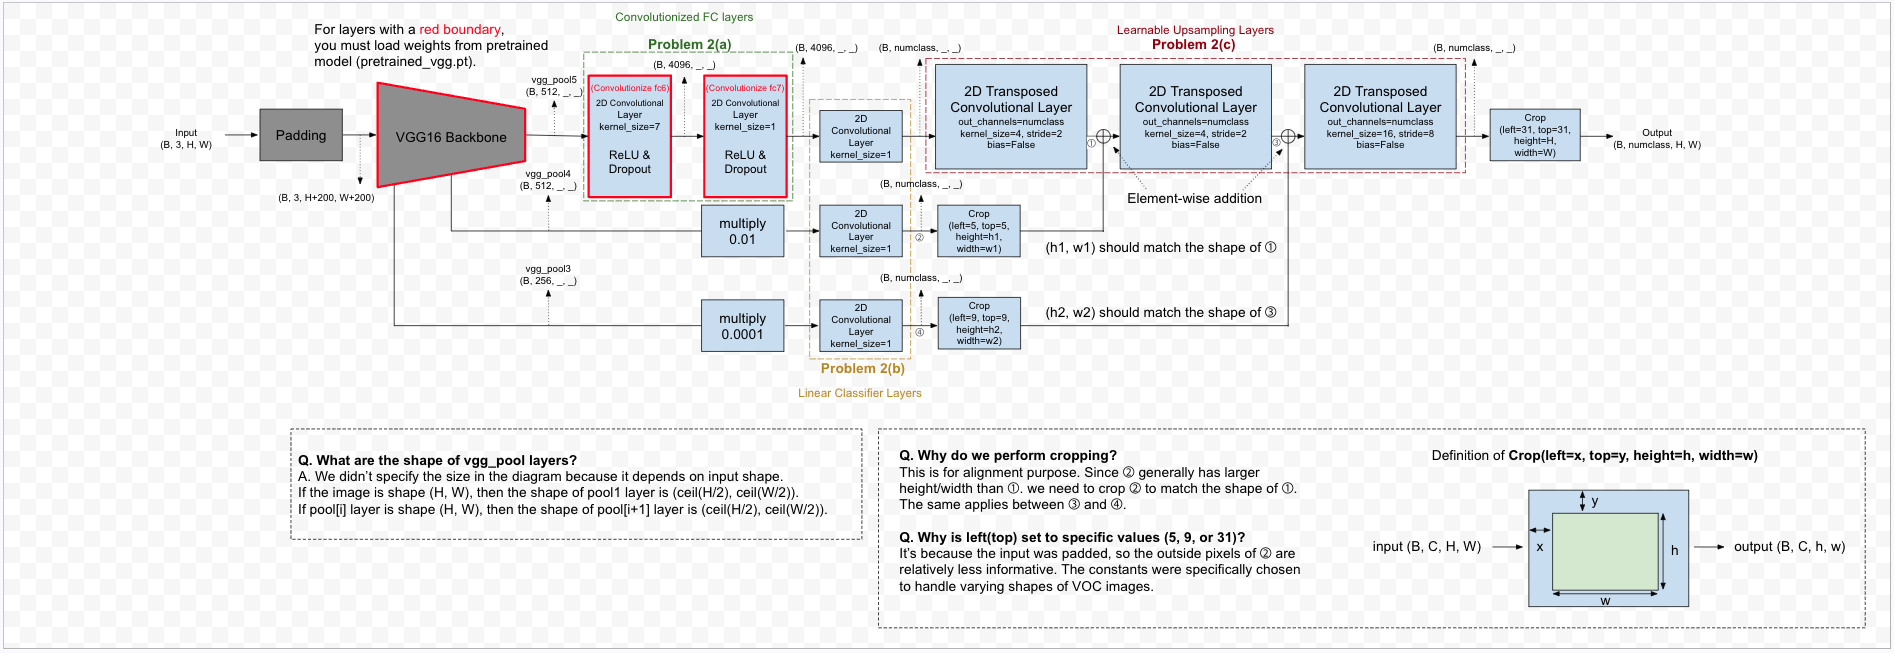

In [23]:
class FCN8(FCN32):
    def __init__(self):
        super().__init__()

        self.numclass = 21

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d()

        # fc layers in vgg are all converted into conv layers.
        #################################
        ## P2(a). Write your code here ##
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=7)
        self.conv7 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=1)
        #################################

        # prediction layers with 1x1 convolution layers.
        #################################
        ## P2(b). Write your code here ##
        self.score_x32 = nn.Conv2d(in_channels=4096, out_channels=self.numclass, kernel_size=1)
        self.score_x16 = nn.Conv2d(in_channels=512, out_channels=self.numclass, kernel_size=1)
        self.score_x8 = nn.Conv2d(in_channels=256, out_channels=self.numclass, kernel_size=1)
        #################################

        # learnable upsampling layers in FCN model.
        #################################
        ## P2(c). Write your code here ##
        self.deconv1 = nn.ConvTranspose2d(in_channels=self.numclass, out_channels=self.numclass,
                                          kernel_size=4, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(in_channels=self.numclass, out_channels=self.numclass,
                                          kernel_size=4, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(in_channels=self.numclass, out_channels=self.numclass,
                                          kernel_size=16, stride=8, bias=False)
        #################################

        # initialize
        self._initialize_weights() # initialize upsampling weight

    def forward(self, x):
        # Padding for aligning to the input size
        padded_x = F.pad(x, [100, 100, 100, 100], "constant", 0)
        vgg_features = self.vgg_forward(padded_x)
        vgg_pool5 = vgg_features['pool5'].detach()
        vgg_pool4 = vgg_features['pool4'].detach()
        vgg_pool3 = vgg_features['pool3'].detach()

        #################################
        ## P2(d). Write your code here ##
        ## Add more lines as you wish. ##
        out = self.dropout(self.relu(self.conv6(vgg_pool5)))
        out = self.dropout(self.relu(self.conv7(out)))
        out = self.score_x32(out)
        
        out = self.deconv1(out)
        out += self.score_x16(vgg_pool4*0.01)[..., 5:5+out.shape[-2], 5:5+out.shape[-1]]
        
        out = self.deconv2(out)
        out += + self.score_x8(vgg_pool3*0.0001)[..., 9:9+out.shape[-2], 9:9+out.shape[-1]]
        
        out = self.deconv3(out)
        out = out[..., 31:31+x.shape[-2], 31:31+x.shape[-1]]
        #################################

        return out

## FCN8 Tests

This section tests your solution for FCN8. **Please do not modify the code!**

In [24]:
def run_tests_fcn8():
    n_pass, n_test = 0, 9

    try:
        net = FCN8()
        print(f"[TEST  1/{n_test} Passed] FCN8.__init__ executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  1/{n_test} Failed] FCN8.__init__ execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
        net = nn.Identity()

    # P2(a). Declare convolutional layers as an alternative to FC layers
    try:
        assert hasattr(net, 'conv6') and hasattr(net, 'conv7')
        print(f"[TEST  2/{n_test} Passed] FCN8.conv6 and FCN8.conv7 found")
        n_pass += 1
    except AssertionError:
        print(f"[TEST  2/{n_test} Failed] FCN8.conv6 or FCN8.conv7 not found")
        net.conv6 = nn.Identity()
        net.conv7 = nn.Identity()
    try:
        assert net.conv6.weight.data.shape == torch.Size([4096, 512, 7, 7]) and net.conv6.bias.data.shape == torch.Size([4096])
        assert net.conv7.weight.data.shape == torch.Size([4096, 4096, 1, 1]) and net.conv7.bias.data.shape == torch.Size([4096])
        print(f"[TEST  3/{n_test} Passed] FCN8.conv6 and FCN8.conv7 weights and biases have correct shapes")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  3/{n_test} Failed] Some of the FCN8.conv6 and FCN8.conv7 weights and biases have incorrect shapes")

    # P2(b). Declare pixel-wise classification layer using 1x1 convolution
    try:
        assert hasattr(net, 'score_x32')
        assert hasattr(net, 'score_x16')
        assert hasattr(net, 'score_x8')
        print(f"[TEST  4/{n_test} Passed] FCN8.score_x32, x16, x8 found")
        n_pass += 1
    except AssertionError:
        print(f"[TEST  4/{n_test} Failed] FCN8.score_x32 or x16 or x8 not found")
        net.score_x32 = nn.Identity()
        net.score_x16 = nn.Identity()
        net.score_x8 = nn.Identity()
    try:
        assert net.score_x32.weight.data.shape == torch.Size([21, 4096, 1, 1]) and net.score_x32.bias.data.shape == torch.Size([21])
        assert net.score_x16.weight.data.shape == torch.Size([21, 512, 1, 1]) and net.score_x32.bias.data.shape == torch.Size([21])
        assert net.score_x8.weight.data.shape == torch.Size([21, 256, 1, 1]) and net.score_x32.bias.data.shape == torch.Size([21])
        print(f"[TEST  5/{n_test} Passed] FCN8.score_x32, x16, x8 weights and biases have correct shapes")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  5/{n_test} Failed] Some of the FCN8.score_x32, x16, x8 weights and biases have incorrect shapes")

    # P2(c). Declare a deconvolution layer
    try:
        assert hasattr(net, 'deconv1')
        assert hasattr(net, 'deconv2')
        assert hasattr(net, 'deconv3')
        print(f"[TEST  6/{n_test} Passed] FCN8.deconv1, deconv2, deconv3 found")
        n_pass += 1
    except AssertionError:
        if not hasattr(net, 'deconv1'):
          print(f"[TEST  6/{n_test} Failed] FCN8.deconv1 not found")
          net.deconv1 = nn.Identity()
        if not hasattr(net, 'deconv2'):
          print(f"[TEST  6/{n_test} Failed] FCN8.deconv2 not found")
          net.deconv2 = nn.Identity()
        if not hasattr(net, 'deconv3'):
          print(f"[TEST  6/{n_test} Failed] FCN8.deconv3 not found")
          net.deconv3 = nn.Identity()
    try:
        assert net.deconv1.weight.data.shape == torch.Size([21, 21, 4, 4]) and net.deconv1.bias is None
        assert net.deconv2.weight.data.shape == torch.Size([21, 21, 4, 4]) and net.deconv2.bias is None
        assert net.deconv3.weight.data.shape == torch.Size([21, 21, 16, 16]) and net.deconv3.bias is None
        print(f"[TEST  7/{n_test} Passed] FCN8.deconv1 weights and biases have correct shapes and configurations")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  7/{n_test} Failed] Some of the FCN8.deconv weights and biases have incorrect shapes or configurations")

    # P2(d). Implement forward method
    net.eval()
    x = train_dataset[100][0].unsqueeze(0)
    # TODO: change it to FCN8
    try:
        pred = net(x)
        print(f"[TEST  8/{n_test} Passed] FCN8.forward executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  8/{n_test} Failed] FCN8.forward execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
    try:
        pred = net(x)
        assert pred.shape == torch.Size([1, 21, x.shape[-2], x.shape[-1]])
        print(f"[TEST  9/{n_test} Passed] FCN8.forward output shape is correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  9/{n_test} Failed] FCN8.forward output shape is incorrect")
    
    '''
    try:
        net.score_x32.weight.data.fill_(0.01)
        net.score_x32.bias.data.fill_(0.01)
        pred = net(x)
        assert (pred.abs().mean() - (0.855009913444519)).abs() <= 1e-5 and (pred.abs().std() - 0.297334223985672) <= 1e-5
        print(f"[TEST 10/{n_test} Passed] FCN8.forward output mean and std are correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST 10/{n_test} Failed] FCN8.forward output mean and std are incorrect; {(pred.abs().mean().item(), pred.abs().std().item())}")
    try:
        net.score_x32.weight.data.fill_(0.01)
        net.score_x32.bias.data.fill_(0.01)
        pred = net(x)
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        rand_loss = (pred - torch.randn_like(pred)).mean()
        net.zero_grad()
        rand_loss.backward()
        assert (net.conv6.weight.grad.abs().mean() - (0.0002523009025026113)).abs() <= 1e-8 and (net.conv6.weight.grad.abs().std() - 0.0006021885783411562) <= 1e-8
        print(f"[TEST 11/{n_test} Passed] FCN8.forward conv6.weight gradient mean and std are correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST 11/{n_test} Failed] FCN8.forward conv6.weight gradient mean and std are incorrect; {(net.conv6.weight.grad.abs().mean().item(), net.conv6.weight.grad.abs().std().item())}")
    '''

    if n_pass == n_test:
        print(f"\n[TEST] 🎉🎉🥳 All {n_pass}/{n_test} tests passed!")
    else:
        print(f"\n[TEST] {n_pass}/{n_test} tests passed.")


run_tests_fcn8()

[TEST  1/9 Passed] FCN8.__init__ executed without errors
[TEST  2/9 Passed] FCN8.conv6 and FCN8.conv7 found
[TEST  3/9 Passed] FCN8.conv6 and FCN8.conv7 weights and biases have correct shapes
[TEST  4/9 Passed] FCN8.score_x32, x16, x8 found
[TEST  5/9 Passed] FCN8.score_x32, x16, x8 weights and biases have correct shapes
[TEST  6/9 Passed] FCN8.deconv1, deconv2, deconv3 found
[TEST  7/9 Passed] FCN8.deconv1 weights and biases have correct shapes and configurations
[TEST  8/9 Passed] FCN8.forward executed without errors
[TEST  9/9 Passed] FCN8.forward output shape is correct

[TEST] 🎉🎉🥳 All 9/9 tests passed!


---
## Train models through the pipeline

In this section, you will
- Create/load directory.
- Select which model to train.
- Create model and optimizer.

The training process will automatically save checkpoints to your Google drive after every epoch under `parent_dir`. Training could take up to 40 minutes per epoch. As we provide  pretrained weights to start with, you will only be training for 10 epochs on your own. Uncomment the lines after `# Select model here.` to choose which model to train.  
**You must load the provided pretrained weights**, otherwise achieving reasonable performance will take much longer.  
**If you would like to resume** from an existing `model.pt`, then
- Comment out the line below `Load pretrained weights here.`,
- Specify `parent_dir` as instructed,
- Run the first code cell again, then run `train_net` with `resume=True` parameter.  

<font color="red">Do not terminate your process right after an epoch has finished.</font> Writing the saved model back to Google drive will take an extra couple of minutes, and aborting in the middle will likely ruin your checkpoint file.

In [31]:
def run_tests_pipeline():
    torch.cuda.manual_seed(42)
    torch.manual_seed(42)
    np.random.seed(42)
    net = FCN8()
    net.eval()
    net.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=21, reduction='none')
    image, label = next(iter(test_loader))
    image = image.to(device)
    label = label.to(device)
    n_pass, n_test = 0, 3

    try:
        output, loss, pred = get_prediction(criterion, net, image, label)
        print(f"[TEST  1/{n_test} Passed] get_prediction executed without errors")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  1/{n_test} Failed] get_prediction execution error; please see the traceback below")
        print(f"\n{traceback.format_exc()}")
        return

    try:
        assert output.shape == torch.Size([1, 21, image.shape[-2], image.shape[-1]])
        print(f"[TEST  2/{n_test} Passed] get_prediction output shape is correct")
        n_pass += 1
    except Exception as e:
        print(f"[TEST  2/{n_test} Failed] get_prediction output shape is incorrect")

    try:
        assert pred.shape == torch.Size([1, image.shape[-2], image.shape[-1]])
        assert pred.dtype == torch.int64
        print(f"[TEST  3/{n_test} Passed] get_prediction pred shape and dtype is correct")
        n_pass += 1
    except:
        print(f"[TEST  3/{n_test} Failed] get_prediction pred shape and dtype is incorrect")

    '''
    try:
        assert (output.abs().mean() - (0.010025606490671635)).abs() <= 1e-8 and (output.abs().std() - 0.00683847488835454) <= 1e-8
        print(f"[TEST  4/{n_test} Passed] get_prediction output mean and std are correct")
        n_pass += 1
    except:
        print(f"[TEST  4/{n_test} Failed] get_prediction output mean and std are incorrect; {(output.abs().mean().item(), output.abs().std().item())}")
    
    try:
        assert (loss - (3.0301403999328613)).abs() <= 1e-5
        print(f"[TEST  5/{n_test} Passed] get_prediction loss is correct")
        n_pass += 1
    except:
        print(f"[TEST  5/{n_test} Failed] get_prediction loss is incorrect; {loss.item()}")

    try:
      assert (pred.float().mean() - (9.697748184204102)).abs() <= 1e-5 and (pred.float().std() - 7.738012790679932) <= 1e-5
      print(f"[TEST  6/{n_test} Passed] get_prediction pred mean and std are correct")
      n_pass += 1
    except:
      print(f"[TEST  6/{n_test} Failed] get_prediction pred mean and std are incorrect; {(pred.float().mean().item(), pred.float().std().item())}")
    '''

    if n_pass == n_test:
        print(f"\n[TEST] 🎉🎉🥳 All {n_pass}/{n_test} tests passed!")

run_tests_pipeline()

[TEST  1/3 Passed] get_prediction executed without errors
[TEST  2/3 Passed] get_prediction output shape is correct
[TEST  3/3 Passed] get_prediction pred shape and dtype is correct

[TEST] 🎉🎉🥳 All 3/3 tests passed!


### Train models through the pipeline

In [32]:
num_trial=0
result_dir= Path(root) / 'results'
parent_dir = result_dir / f'trial_{num_trial}'
while parent_dir.is_dir():
    num_trial = int(parent_dir.name.replace('trial_',''))
    parent_dir = result_dir / f'trial_{num_trial+1}'

# modify parent_dir here if you want to resume from a checkpoint, or to rename directory.
# parent_dir = result_dir / 'trial_99'
print(f'Logs and ckpts will be saved in : {parent_dir}')

log_dir = parent_dir
ckpt_dir = parent_dir
ckpt_path = parent_dir / 'model.pt'
writer = SummaryWriter(log_dir)

# load pretrained weights.
pretrained_path = Path(root) / 'pretrained_vgg16.pt'
pretrained_VGG = vgg16().to(device)
pretrained_VGG.load_state_dict(torch.load(pretrained_path, map_location=device))

# select model here.
#####################################
model2 = FCN8().to(device)
#####################################

# load pretrained weights here.
model2.load_pretrained(pretrained_VGG)

# define optimizer.
# according to FCN paper, we doubled the learning rate of bias compared to that of weight.
optimizer = SGD([{'params': get_parameters(model2, True), 'lr': args.lr * 2, 'weight_decay': 0},
                 {'params': get_parameters(model2, False)}],
                lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

Logs and ckpts will be saved in : results/trial_3


/tmp/ipykernel_358825/2437352581.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_VGG.load_state_dict(torch.load(pretrained_path, map_location=device))


In [33]:
train_net(model2, resume=False)

2it [00:00,  7.44it/s]

Epoch : 0 || 0/8498 || loss : 2.971, iou : 1.317 pixel_acc : 6.943


1002it [01:16, 13.96it/s]

Epoch : 0 || 1000/8498 || loss : 0.618, iou : 40.043 pixel_acc : 81.740


2002it [02:30, 13.93it/s]

Epoch : 0 || 2000/8498 || loss : 0.489, iou : 68.080 pixel_acc : 87.339


3002it [03:43, 13.51it/s]

Epoch : 0 || 3000/8498 || loss : 0.416, iou : 71.004 pixel_acc : 87.950


4002it [04:56, 13.86it/s]

Epoch : 0 || 4000/8498 || loss : 1.103, iou : 31.890 pixel_acc : 60.262


5002it [06:09, 13.97it/s]

Epoch : 0 || 5000/8498 || loss : 0.258, iou : 51.715 pixel_acc : 91.739


6002it [07:22, 13.63it/s]

Epoch : 0 || 6000/8498 || loss : 0.153, iou : 69.690 pixel_acc : 96.753


7002it [08:35, 13.86it/s]

Epoch : 0 || 7000/8498 || loss : 0.855, iou : 20.875 pixel_acc : 76.411


8002it [09:47, 13.73it/s]

Epoch : 0 || 8000/8498 || loss : 1.291, iou : 26.798 pixel_acc : 73.810


8498it [10:23, 13.62it/s]


>> Epoch : 0 || AVG loss : 0.773, iou : 45.519 pixel_acc : 79.389 624.464 secs


2857it [02:13, 21.35it/s]


>> Epoch : 0 || AVG valid loss : 0.568, iou : 51.750 pixel_acc : 83.191 624.464 secs


2it [00:00, 12.46it/s]

Epoch : 1 || 0/8498 || loss : 0.208, iou : 32.329 pixel_acc : 96.898


1002it [01:12, 13.71it/s]

Epoch : 1 || 1000/8498 || loss : 0.987, iou : 24.498 pixel_acc : 65.073


2002it [02:24, 13.78it/s]

Epoch : 1 || 2000/8498 || loss : 0.582, iou : 31.961 pixel_acc : 81.846


3002it [03:36, 14.11it/s]

Epoch : 1 || 3000/8498 || loss : 1.090, iou : 26.924 pixel_acc : 68.110


4004it [04:48, 14.72it/s]

Epoch : 1 || 4000/8498 || loss : 0.812, iou : 52.913 pixel_acc : 73.924


5002it [06:01, 13.75it/s]

Epoch : 1 || 5000/8498 || loss : 0.112, iou : 49.544 pixel_acc : 99.089


6002it [07:13, 13.70it/s]

Epoch : 1 || 6000/8498 || loss : 1.059, iou : 28.090 pixel_acc : 65.041


7002it [08:25, 13.61it/s]

Epoch : 1 || 7000/8498 || loss : 0.253, iou : 80.666 pixel_acc : 90.643


8002it [09:38, 13.86it/s]

Epoch : 1 || 8000/8498 || loss : 0.363, iou : 53.957 pixel_acc : 92.713


8498it [10:14, 13.84it/s]


>> Epoch : 1 || AVG loss : 0.563, iou : 51.199 pixel_acc : 83.049 614.766 secs


2857it [02:13, 21.34it/s]


>> Epoch : 1 || AVG valid loss : 0.513, iou : 53.740 pixel_acc : 84.190 614.766 secs
>> Best validation set iou: 0.5373999301433348


# Part 3. Aggregating Results

After you've trained FCN32 or FCN8, load your best models and run the following block to check validation accuracy, and compare IoU improvements made by CRF. Since the validation set contains nearly 3,000 images, this will take up to 30 minutes.

You can regard that your implementation is correct if performance is in ± 2%p (pixel accuracy), 0.01 (mIoU) of the following values:
- FCN32
  - Without CRF: 88% pixel accuracy, 0.596 mIoU
- FCN8
  - Without CRF: 89% pixel accuracy, 0.614 mIoU.  

The exact values are subject to change, don't worry too much if you missed the range by a small margin.

In [34]:
# specify path to your best trained model.
# for example if you want to FCN32 load from folder 'trial_5', modify 'trial_99' into 'trial_5'.
FCN32_path = result_dir / 'trial_1' / 'best.pt'
FCN8_path = result_dir / 'trial_5' / 'best.pt'

# OPTIONAL: Read text below this code cell.
use_crf = False

criterion = nn.CrossEntropyLoss(ignore_index=21, reduction='none')
colorize = Colorize(21, get_color_map())

for net in [model, model2]:
    net.eval()

    valid_loss_total = 0
    valid_ious = []
    valid_pixel_accs = []
    valid_ious_crf = []
    valid_pixel_accs_crf = []

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            # Move variables to gpu.
            image = image.to(device)
            label = label.to(device)

            output, loss, pred = get_prediction(criterion, net, image, label)
            # CRF for some images.
            if use_crf:
                image_permuted = image.cpu().permute(1, 0, 2, 3)
                un_norm = torch.zeros_like(image_permuted)
                for idx, (im, m, s) in enumerate(zip(image_permuted, mean, std)):
                    un_norm[idx] = (im * s) + m
                un_norm = un_norm.permute(1, 0, 2, 3)

                output_softmax = torch.nn.functional.softmax(output, dim=1).detach().cpu()
                un_norm_int = (un_norm * 255).squeeze().permute(1, 2, 0).numpy().astype(np.ubyte)
                pred_crf = dense_crf(un_norm_int, output_softmax.squeeze().numpy())
                pred_crf = np.expand_dims(np.argmax(pred_crf, 0), 0)

                target = label.squeeze(1).cpu().numpy()
                acc_crf, mean_iu_crf = label_accuracy_score(target, pred_crf, n_class=21)
                valid_pixel_accs_crf.append(acc_crf)
                valid_ious_crf.append(mean_iu_crf)

            target = label.squeeze(1).cpu().numpy()
            acc, mean_iu = label_accuracy_score(target, pred.cpu().numpy(), n_class=21)

            # update total loss.
            valid_loss_total += loss.item()

            valid_pixel_accs.append(acc)
            valid_ious.append(mean_iu)

            # # this is only for testing
            # if batch_idx > 50:
            #   break

        # calculate average IoU
        total_valid_ious = np.array(valid_ious).T
        total_valid_ious = np.nanmean(total_valid_ious).mean()
        total_valid_pixel_acc = np.array(valid_pixel_accs).mean()

        print(f'[{type(net).__name__}]')
        print(f'Pixel accuracy: {total_valid_pixel_acc * 100:.3f}, mIoU: {total_valid_ious:.3f}')

        if use_crf:
            total_valid_ious_crf = np.array(valid_ious_crf).T
            total_valid_ious_crf = np.nanmean(total_valid_ious_crf).mean()
            total_valid_pixel_acc_crf = np.array(valid_pixel_accs_crf).mean()
            print(f'CRF Pixel accuracy: {total_valid_pixel_acc_crf * 100:.3f}, CRF mIoU: {total_valid_ious_crf:.3f}')


[FCN32]
Pixel accuracy: 83.586, mIoU: 0.525
[FCN8]
Pixel accuracy: 84.190, mIoU: 0.537
